<a href="https://colab.research.google.com/github/vicente-gonzalez-ruiz/learned_image_compression/blob/main/notebooks/06__one_layer_AE_MNIST_RD_optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Considering the RD trade-off
So far, the autoencoder has tried to minimize the distortion ($D$) without considering the number of bits that the encoding of the latent space requires. When we use an entropy encoder, where the length of the code-stream depends on the statistics of the symbols of the latent space, it is required to optimize also considering the length of the code-stream. Now $R$ should also be minimized.

Unfortunately, $D$ and $R$ cannot be minimized at the same time becase one of them are inversely related with the other (for example, if $R$ increases, $D$ decreases). For this reason, we need to define a cost function that controls such trade-off between both optimization objectives. Such cost function is usually defined as the Lagrangian
\begin{equation}
  J = R + \lambda D,
\end{equation}
where the Lagrange multiplier $\lambda$ determines a point in the RD curve.

Sumarizing, now we optimize the autoencoder by minimizing $J$. $R$ is estimated using the entropy of the latent space.

rate:  tf.Tensor(3.651163018260358, shape=(), dtype=float64)
distortion:  tf.Tensor(
[0.22400889 0.22535287 0.23113823 0.22818309 0.23238844 0.23402384
 0.2248708  0.23320484 0.22835794 0.24356745 0.22335441 0.2285727
 0.23331612 0.23262782 0.22568476 0.23114344 0.23143658 0.23427838
 0.235758   0.22906092 0.22957142 0.23281124 0.23381619 0.22428112
 0.23019092 0.22864518 0.2359544  0.22377186 0.23249874 0.22994556
 0.22483757 0.23052433], shape=(32,), dtype=float32)
469/469 [==============================] - 56s 115ms/step - loss: 32.1144 - distortion_loss: 0.0551 - rate_loss: 4.5794 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 4.5794 - val_loss: 20.7255 - val_distortion_loss: 0.0322 - val_rate_loss: 4.6223 - val_distortion_pass_through_loss: 0.0322 - val_rate_pass_through_loss: 4.6240
Model: "trainer_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 analysis_transform (Sequen  (N

<Figure size 640x480 with 0 Axes>

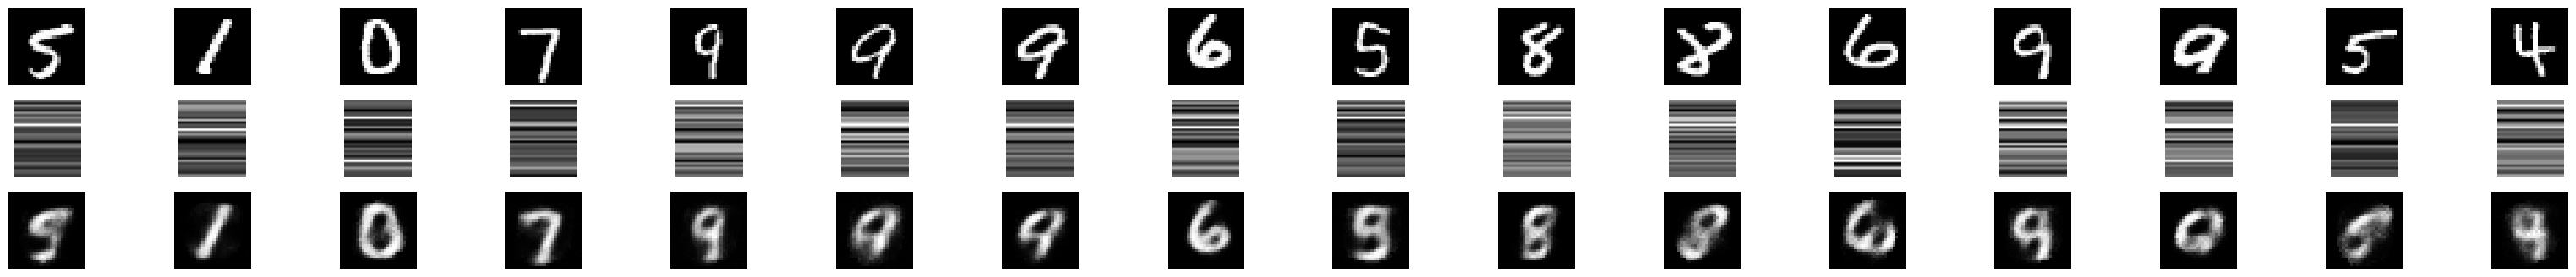

In [4]:
# Rate is estimated with the entropy of the latent.
# Distortion is MSE.
# Noise is added during tranining.
# Quantization is simulated when decoding (rounding to the nearest integer in 16 bits the latent space).

import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split
from skimage.transform import resize
#from scipy.stats import entropy
#tf.compat.v1.enable_eager_execution()

# https://www.tensorflow.org/datasets/catalog/
DATASET = 'mnist'
#DATASET = 'fashion_mnist'
#URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-images-idx3-ubyte.gz"

EPOCHS = 1

LATENT_SPACE_LENGTH = 32

img_width = 28
img_height = 28
img_length = img_height * img_width

train_DS, test_DS = tfds.load(
    DATASET,
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)

class AddNoise(keras.layers.Layer):

    def __init__(self, units=32, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        outputs = inputs
        outputs += tf.random.uniform(shape=tf.shape(inputs), minval=-.5, maxval=.5)
        return outputs

# Unused
class Quantization_8bits(keras.layers.Layer):

    def __init__(self, units=32, **kwargs):
        super().__init__(**kwargs)
        self.quantized_vals = 0

    def call(self, inputs):
        outputs = inputs
        #print("a1", tf.reduce_min(outputs))
        #print("a2", tf.reduce_max(outputs))
        #outputs = tf.keras.activations.sigmoid(outputs - 0.5)#(outputs + 0.5)
        #print("d1", tf.reduce_min(outputs))
        #print("d2", tf.reduce_max(outputs))
        #output = outputs - 0.5
        outputs = tf.saturate_cast(tf.round(outputs * 255.), tf.int16)
        #outputs = tf.saturate_cast(tf.round(outputs * 255.), tf.int8)
        self.quantized_vals = outputs
        outputs = tf.cast(outputs, tf.float32) / 255.0
        return outputs

    def get_vals(self):
        return self.quantized_vals

def encode(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Input(
            shape=(img_length,), name="inputs"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation="relu", name="latent"),
      AddNoise(units=LATENT_SPACE_LENGTH, name="add_noise"),
  ], name="analysis_transform")

def decode():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          img_length, use_bias=True, activation="sigmoid", name="outputs"),
  ], name="synthesis_transform")

# Unused
def quantized_decode():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      Quantization_8bits(units=LATENT_SPACE_LENGTH, name="quantization"),
      tf.keras.layers.Dense(
          img_length, use_bias=True, activation="sigmoid", name="outputs"),
  ], name="synthesis_transform")

def estimate_rate(x):

    def entropy(row):
        _, _, count = tf.unique_with_counts(row)
        prob = count / tf.reduce_sum(count)
        _2 = tf.ones_like(prob)*2
        log_2 = tf.cast(tf.math.log(_2), tf.float64)
        #print(log_2.dtype, prob.dtype, tf.math.log(prob).dtype)
        #return -tf.reduce_sum(prob * tf.math.log(prob))
        return -tf.reduce_sum(prob * tf.math.log(prob)/log_2)

    #     rev = tf.map_fn(row_entropy, new_f_w_t,dtype=tf.float32)
    #entropy_batch = []
    #for j in range(len(batch)):
    #    entropy_batch.append(entropy(batch, base=2))
    #new_f_w_t = tf.histogram_fixed_width_bins(x, value_ranges, nbins)
    #rev = tf.map_fn(row_entropy, new_f_w_t,dtype=tf.float32)
    #tf.print("x.shape =", x.shape)
    max_val = tf.reduce_max(x)
    #tf.print("max_val =", max_val)
    value_ranges = [0.0, max_val] # Estimation of the range of values of the neurons of the hidden layer
    nbins = 256 # 256 quantization levels
    #print("estimate_rate.max(x)=",
    #      tf.reduce_max(x, axis = 1, keepdims = True),
    #      "estimate_rate.min(x)=",
    #      tf.reduce_min(x, axis = 1, keepdims = True))
    histograms = tf.cast(tf.histogram_fixed_width_bins(x, value_ranges, nbins), tf.float32)
    entropies = tf.map_fn(fn=entropy, elems=histograms, dtype=tf.float64)
    rate = tf.reduce_sum(entropies)
    #print("----------------___", histograms.dtype, entropies.dtype, rate.dtype)

    rate /= (tf.cast(tf.size(entropies), tf.float64)) # In (estimated) bits/symbol
    #tf.print("rate=", rate)
    return rate

class Trainer(tf.keras.Model):

    def __init__(self, latent_dims):
        super().__init__()
        self.encode = encode(latent_dims)
        self.decode = decode()

    def call(self, x):
        """Computes rate and distortion losses."""
        # Ensure inputs are floats in the range (0, 1).
        #tf.print("x=", x) # <- produces 0
        #print("max x", tf.reduce_max(x))

        x = tf.cast(x, self.compute_dtype) / 255.
        x = tf.reshape(x, (-1, 28*28))

        # Compute latent space representation y, perturb it and model its entropy,
        # then compute the reconstructed pixel-level representation x_hat.
        y = self.encode(x)
        #print("size(y)=", tf.size(y))
        #print("len(y)=", len(y))
        #print("shape(y)", tf.shape(y))
        #print("size(x)=", tf.size(x))
        #tf.print("x=", x)
        #tf.print("y=", y)

        rate = estimate_rate(y)
        x_hat = self.decode(y)
        #print("Autoencoder.call.max(y)=", tf.reduce_max(y))
        #print("Autoencoder.call.max(x)=", tf.reduce_max(x))
        #print("Autoencoder.call.max(x_hat)=", tf.reduce_max(x_hat))

        # Average number of bits per MNIST digit.
        #rate = tf.reduce_mean(rate)

        # Mean absolute difference across pixels.
        #distortion = tf.reduce_mean(abs(x - x_hat))
        # MSE (see https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss)
        distortion = tf.reduce_mean(tf.math.square(x - x_hat), axis=-1)
        return dict(rate=rate, distortion=distortion)

(example_batch, _), = test_DS.batch(32).take(1)
trainer = Trainer(LATENT_SPACE_LENGTH)
example_output = trainer(example_batch)

print("rate: ", example_output["rate"])
print("distortion: ", example_output["distortion"])

def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def configure_training(lmbda, latent_dims=32):
    trainer = Trainer(latent_dims)
    trainer.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        # Just pass through rate and distortion as losses/metrics.
        loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
        metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
        loss_weights=dict(rate=1., distortion=lmbda),)
    return trainer

def add_rd_targets(image, label):
    # Training is unsupervised, so labels aren't necessary here. However, we
    # need to add "dummy" targets for rate and distortion.
    #tf.print(image) <- produce 0
    #tf.print(label) <- produce labels
    processed_img = tf.reshape(image, (img_height * img_width, 1))
    #processed_img = tf.cast(processed_img, tf.float32) / 255.
    #tf.print(processed_img)
    return processed_img, dict(rate=0., distortion=0.)

def train(lmbda, epochs=5, latent_dims=32):
    trainer = configure_training(lmbda, latent_dims)
    #print("-----------")
    #tf.print(train_DS.take(16))
    #print("-----------")
    trainer.fit(
        train_DS.map(add_rd_targets).batch(128).prefetch(8),
        epochs=epochs,
        validation_data=test_DS.map(add_rd_targets).batch(128).cache(),
        #validation_data=train_DS.map(add_rd_targets).batch(128).cache(),
        validation_freq=1,
        verbose=1,
    )
    return trainer

trainer = train(lmbda=500, epochs=EPOCHS, latent_dims=LATENT_SPACE_LENGTH)
trainer.summary()

class Compressor(tf.keras.Model):
    def __init__(self, analysis_transform):
        super().__init__()
        self.analysis_transform = analysis_transform

    def call(self, x):
        # Ensure inputs are floats in the range (0, 1).
        x = tf.cast(x, self.compute_dtype) / 255.
        x = tf.reshape(x, (-1, 28*28))
        y = self.analysis_transform(x)
        #tf.print(y)
        #print("size(y)=", tf.size(y))
        # Also return the exact information content of each digit.
        rate = estimate_rate(y)
        rate = tf.reduce_mean(rate)
        return y, rate

class Decompressor(tf.keras.Model):
    def __init__(self, synthesis_transform):
        super().__init__()
        self.synthesis_transform = synthesis_transform

    def call(self, y):
        #tf.print(y)
        print("Decompressor.call.max(y)", tf.reduce_max(y))
        print("Decompressor.call.min(y)", tf.reduce_min(y))
        quantized_y = tf.saturate_cast(tf.round(y * 255.), tf.int16)
        #quantized_y = y
        print("Decompressor.call.max(quantized_y)", tf.reduce_max(quantized_y))
        print("Decompressor.call.min(quantized_y)", tf.reduce_min(quantized_y))
        quantized_y = tf.saturate_cast(quantized_y / 255, tf.float32 )
        x_hat = self.synthesis_transform(quantized_y)
        #print("Decompressor.call.max(x_hat)", tf.reduce_max(x_hat))
        # Scale and cast back to 8-bit integer.
        #tf.print("Decompressor.call.xhat =", x_hat)
        #print("max(Decompressor.call.x_hat()", tf.reduce_max(x_hat))
        x_hat = tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)
        tf.print("Decompressor.call.unique(x_hat) =", tf.unique_with_counts(tf.reshape(x_hat, [-1])))
        return x_hat

def make_mnist_codec(trainer, **kwargs):
    # The entropy model must be created with `compression=True` and the same
    # instance must be shared between compressor and decompressor.
    compressor = Compressor(trainer.encode)
    decompressor = Decompressor(trainer.decode)
    return compressor, decompressor

compressor, decompressor = make_mnist_codec(trainer)

(originals, _), = test_DS.batch(16).skip(3).take(1)
y, entropies = compressor(originals)
print("shape(y)=", tf.shape(y), "max(y)=", tf.reduce_max(y), "entropies=", entropies)
reconstructed_imgs = decompressor(y)
print("shape(recons)=", tf.shape(reconstructed_imgs), "max(recons)=", tf.reduce_max(reconstructed_imgs))
n = len(reconstructed_imgs)
plt.gray()
plt.figure(figsize=(40,4))
for i in range(n):
    ax = plt.subplot(3, n, i + 1 )
    plt.imshow(tf.reshape(originals[i], (img_height, img_width)))
    plt.axis("off")
for i in range(n):
    ax = plt.subplot(3, n, i + 1 + n)
    #tf.print(reconstructed_imgs[i])
    plt.imshow(resize(y[i],(LATENT_SPACE_LENGTH, img_width)))
    #plt.imshow(tf.reshape(reconstructed_imgs[i], (img_height, img_width)))
    plt.axis("off")
for i in range(n):
    ax = plt.subplot(3, n, i + 1 + 2*n)
    #tf.print(reconstructed_imgs[i])
    plt.imshow(tf.reshape(reconstructed_imgs[i], (img_height, img_width)))
    plt.axis("off")
plt.show()